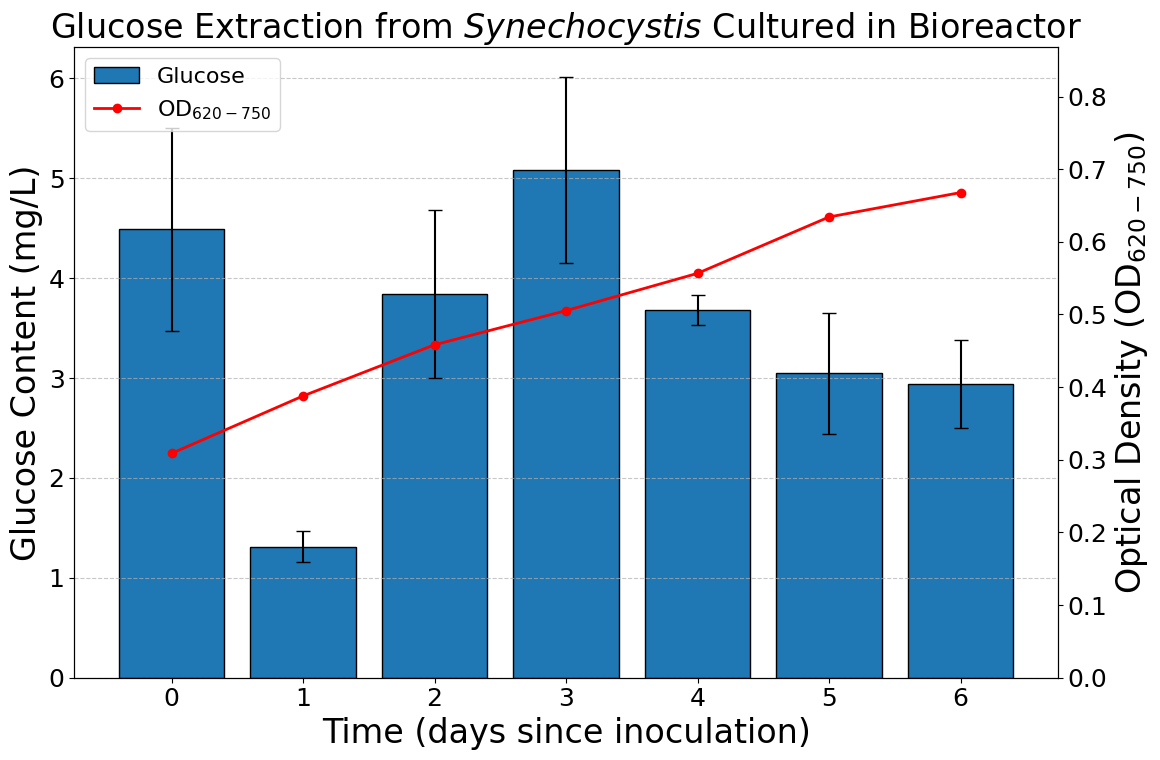

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---------- Config ----------
GLUCOSE_XLSX = 'Data July 11.xlsx'
GLUCOSE_SHEET = 'Glucose'

COLOR_LOG = 'color_log_2025-07-11_10-32-01.txt'  # your OD log file
I_O = 41850  # incident intensity for OD calculation
OD_CHANNEL = 'Red'  # which channel to use for OD (as in your guide code)

# Make fonts larger by default
plt.rcParams.update({'font.size': 20})

# ---------- Load Glucose ----------
glucose_df = pd.read_excel(GLUCOSE_XLSX, sheet_name=GLUCOSE_SHEET)
glucose_df.columns = glucose_df.columns.str.strip()

# Identify a Day column and normalize it to a zero-based integer day index
if 'Day' in glucose_df.columns:
    day_series = glucose_df['Day']
else:
    first_col = glucose_df.columns[0]
    day_series = glucose_df[first_col]

day_dt = pd.to_datetime(day_series, errors='coerce')
if day_dt.notna().any() and day_dt.nunique() > 1:
    day_idx_gluc = (day_dt - day_dt.min()).dt.days
else:
    day_num = pd.to_numeric(day_series, errors='coerce')
    if day_num.notna().any():
        day_idx_gluc = (day_num - day_num.min()).astype(int)
    else:
        day_idx_gluc = pd.Series(range(len(glucose_df)), index=glucose_df.index)

glucose_df = glucose_df.assign(Day=day_idx_gluc)

# Determine glucose mean/std columns
avg_col = 'Average (mg/L)'
std_col = 'Std Dev'

if avg_col in glucose_df.columns and std_col in glucose_df.columns:
    glucose_df[avg_col] = pd.to_numeric(glucose_df[avg_col], errors='coerce')
    glucose_df[std_col] = pd.to_numeric(glucose_df[std_col], errors='coerce')
    grouped_glucose = (
        glucose_df.groupby('Day', as_index=False)
        .agg(Mean_Glucose=(avg_col, 'mean'), Std_Dev_Glucose=(std_col, 'mean'))
    )
else:
    gluc_cols = [c for c in glucose_df.columns
                 if ('glucose' in c.lower()) and ('mg/l' in c.lower())]
    if not gluc_cols:
        raise ValueError("Couldn't find glucose columns.")
    tmp = glucose_df[['Day'] + gluc_cols].copy()
    tmp[gluc_cols] = tmp[gluc_cols].apply(pd.to_numeric, errors='coerce')
    tmp = tmp.dropna(subset=gluc_cols, how='all')
    tmp['Mean_Glucose'] = tmp[gluc_cols].mean(axis=1)
    tmp['Std_Dev_Glucose'] = tmp[gluc_cols].std(axis=1)
    grouped_glucose = (
        tmp.groupby('Day', as_index=False)
           .agg(Mean_Glucose=('Mean_Glucose', 'mean'),
                Std_Dev_Glucose=('Std_Dev_Glucose', 'mean'))
    )

# ---------- Load OD ----------
od_df = pd.read_csv(
    COLOR_LOG,
    header=None,
    names=['Datetime', 'Red', 'Green', 'Blue', 'Clear']
)
od_df['Datetime'] = pd.to_datetime(od_df['Datetime'], errors='coerce')
od_df = od_df.dropna(subset=['Datetime']).copy()
od_df['OD'] = np.log10(I_O / od_df[OD_CHANNEL])
start_dt = od_df['Datetime'].min()
od_df['Day'] = np.floor((od_df['Datetime'] - start_dt).dt.total_seconds() / (24 * 3600)).astype(int)
grouped_od = od_df.groupby('Day', as_index=False)['OD'].mean()

# ---------- Merge ----------
merged = pd.merge(grouped_glucose, grouped_od, on='Day', how='outer').sort_values('Day')

# ---------- Plot ----------
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bars: Glucose (left y-axis)
ax1.bar(
    merged['Day'],
    merged['Mean_Glucose'],
    yerr=merged['Std_Dev_Glucose'],
    capsize=5,
    edgecolor='black',
    label='Glucose'
)
ax1.set_xlabel('Time (days since inoculation)', fontsize=24)
ax1.set_ylabel('Glucose Content (mg/L)', fontsize=24)
ax1.tick_params(axis='y', labelsize=18)
ax1.tick_params(axis='x', labelsize=18)
ax1.set_xticks(merged['Day'])  # ticks are just 0, 1, 2…
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Line: OD (right y-axis)
ax2 = ax1.twinx()
ax2.plot(
    merged['Day'],
    merged['OD'],
    marker='o',
    color='red',
    linewidth=2,
    label='OD$_{620-750}$'
)
ax2.set_ylabel(r'Optical Density (OD$_{620-750}$)', fontsize=24)
ax2.tick_params(axis='y', labelsize=18)

if merged['OD'].notna().any():
    max_od = merged['OD'].max()
    ax2.set_ylim(0, max_od * 1.3 if np.isfinite(max_od) else 1.0)

# Title + combined legend
plt.title('Glucose Extraction from $\it{Synechocystis}$ Cultured in Bioreactor', fontsize=24)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=16)

plt.tight_layout()
plt.show()
